In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_train.csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)

In [4]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)

In [53]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tamil_offensive_full_test.csv',delimiter='\t',names=['text'])

In [9]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [11]:
tokenizer.fit_on_texts(train['text'].values)
X_train = tokenizer.texts_to_sequences(train['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [12]:
tokenizer.fit_on_texts(val['text'].values)
X_val = tokenizer.texts_to_sequences(val['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [54]:
tokenizer.fit_on_texts(test['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

In [14]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2021-01-08 11:31:45--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-08 11:31:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.91MB/s    in 6m 28s  

2021-01-08 11:38:13 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [15]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [16]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_index = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
glove_file.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [17]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

77584
2001


In [18]:
from keras.models import Sequential
from keras.initializers import Constant
from keras import layers
embed_dim = 100

model = Sequential()
model.add(layers.Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 265,002
Trainable params: 265,002
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [20]:
y_train = train['label']
y_val = val['label']

In [21]:
Y_train=pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values

In [22]:
history = model.fit(X_train, Y_train,batch_size = 64, validation_data=(X_val,Y_val), epochs=10, verbose=2)

Epoch 1/10
550/550 - 169s - loss: 0.9189 - accuracy: 0.7193 - val_loss: 1.0306 - val_accuracy: 0.7140
Epoch 2/10
550/550 - 168s - loss: 0.7289 - accuracy: 0.7584 - val_loss: 1.0809 - val_accuracy: 0.7065
Epoch 3/10
550/550 - 167s - loss: 0.6443 - accuracy: 0.7806 - val_loss: 1.1498 - val_accuracy: 0.7076
Epoch 4/10
550/550 - 167s - loss: 0.5857 - accuracy: 0.7985 - val_loss: 1.2216 - val_accuracy: 0.6976
Epoch 5/10
550/550 - 167s - loss: 0.5293 - accuracy: 0.8138 - val_loss: 1.2386 - val_accuracy: 0.6809
Epoch 6/10
550/550 - 168s - loss: 0.4884 - accuracy: 0.8266 - val_loss: 1.3196 - val_accuracy: 0.6830
Epoch 7/10
550/550 - 166s - loss: 0.4396 - accuracy: 0.8464 - val_loss: 1.3864 - val_accuracy: 0.6766
Epoch 8/10
550/550 - 167s - loss: 0.3983 - accuracy: 0.8588 - val_loss: 1.4994 - val_accuracy: 0.6682
Epoch 9/10
550/550 - 167s - loss: 0.3631 - accuracy: 0.8719 - val_loss: 1.5436 - val_accuracy: 0.6721
Epoch 10/10
550/550 - 168s - loss: 0.3363 - accuracy: 0.8811 - val_loss: 1.6621 - 

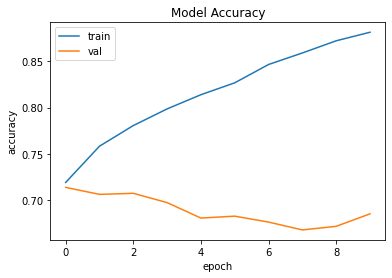

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [30]:
# score = model.evaluate(X_val,Y_val,verbose=1)
predictions = np.argmax(model.predict(X_val),axis = -1)

# print("Test score is {}".format(score[0]))
# print("Test Accuracy is {}".format(score[1]))

In [47]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)

In [29]:
print(val_acc)
print(train_acc)

0.6855059266090393
0.9337203502655029


In [55]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)

In [44]:
import numpy as np
rounded_labels=np.argmax(Y_val, axis=1)

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      3193
           1       0.10      0.03      0.04       356
           2       0.14      0.05      0.07       295
           3       0.19      0.08      0.11       307
           4       0.05      0.01      0.02       172
           5       0.00      0.00      0.00        65

    accuracy                           0.69      4388
   macro avg       0.20      0.18      0.18      4388
weighted avg       0.57      0.69      0.61      4388



In [56]:
print(rounded_predictions)

[0 0 0 ... 1 1 0]


In [59]:
a = {'id':[i for i in range(4392)]}
a = pd.DataFrame(a)

df = pd.DataFrame({'id':a.id,'labels':rounded_predictions})
df.labels = df.labels.apply({0:'Not_offensive',1:'Offensive_Untargetede',2:'Offensive_Targeted_Insult_Group',3:'Offensive_Targeted_Insult_Individual',4:'not-Tamil', 5:'Offensive_Targeted_Insult_Other'}.get)


In [60]:
df

,id,labels
0,0,Not_offensive
1,1,Not_offensive
2,2,Not_offensive
3,3,Not_offensive
4,4,Not_offensive
...,...,...
4387,4387,Not_offensive
4388,4388,Not_offensive
4389,4389,Offensive_Untargetede
4390,4390,Offensive_Untargetede


In [61]:
df.to_csv('CNN_GloVe_Tamil_submission.csv',index=False)
from google.colab import files
files.download("CNN_GloVe_Tamil_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>